In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.encoder = nn.RNNCell(self.input_size, self.hidden_size)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.encoder(input, hidden) ###### To be filled ######
        output = self.decoder(hidden) ###### To be filled ######

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (encoder): RNNCell(100, 100)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.3000762462615967
generated sequence: WN
shet botrghl thshBor enbvIrRr
inr I wytnotttraotTsnrao dhd troaahe haehewMYehen noauhai:sbaurir. h

iter:199/20000 loss:2.772829055786133
generated sequence: WA shonliy milr,

M wemmasN
GIEN o! seyted mat mot yer ly bamitiuy thandhe?ald lis en howed,
NSEitot!

iter:299/20000 loss:2.468703269958496
generated sequence: Waila. waenar, Ky lith? giveore,CCoB,
At EB huml ant bame tuthI fouth?u
CKoFd IUtVAN ANEN:
Ed: ure wc

iter:399/20000 loss:2.3700408935546875
generated sequence: Whis tid ow, mume to bofgyalathes sitr aed witce fucenedis arthiv? Ghath, Dis arousd;yaf hib hy eo, h

iter:499/20000 loss:2.3213024139404297
generated sequence: Whaus wima misos; ay youss and on comes mat uryous rosta Piulp
I weis hawgomkecsengag'the de ble asil

iter:599/20000 loss:2.2904090881347656
generated sequence: Weltod

{O.
Thou woundinges yoo s mame re soud hill in soud whos thy, qusaeg bs co mish, I yne;
Af yo

iter:699/20000 loss:2.245340108

iter:5199/20000 loss:1.902431845664978
generated sequence: Whrat's dreat you seaver, with hay
I lesserged
swelf agaressing wo-fare;
I anging! themer and storn t

iter:5299/20000 loss:1.8880363702774048
generated sequence: Why maill's or tho preves, thou hapl ho ap this het has her both,
Arome,
Whepe our I stoul be it;
But

iter:5399/20000 loss:1.8854702711105347
generated sequence: WARDUCE CIORD:
I am
oling
Come than bide and I would manrendes? Lifemunctging, Camoudonow: a courys b

iter:5499/20000 loss:1.909894585609436
generated sequence: What hed raseroom is see sour land onjudale aliof the are,
And fur the cristur my braid know youl fer

iter:5599/20000 loss:1.9175972938537598
generated sequence: Whoincay even ener sour tearch: him, Lir IN Evids hene, to hight I would he Illif!
Sende! heart frous

iter:5699/20000 loss:1.8735967874526978
generated sequence: Where of one frod eremore iccelther, for't as anttang,
She chout thou;
there thiug at a bligran?
Well

iter:5799/20000 loss:1.9

iter:10299/20000 loss:1.8361936807632446
generated sequence: Wstendes, he house yow and
Of Burbewerad Het'st wistrend in mhe with race or the witlds. me is in old

iter:10399/20000 loss:1.8561065196990967
generated sequence: Ward'd air And pringed him and hear with sorised him, go that.
What be no, antieve than
Peacen
boy, b

iter:10499/20000 loss:1.8625332117080688
generated sequence: Well thered,
Les wouldve pleman:
And is sount?
I tole itle, oomareng.

GLESIUS

MANDA:
I chang.

PiEN

iter:10599/20000 loss:1.8226121664047241
generated sequence: Wear?

Sisse I repee have?
I kingous at thy leave I loag.

KING RICHARD III:

KINGln:
No kingy me; us

iter:10699/20000 loss:1.840370535850525
generated sequence: Weed,
In the choure I smindelige
comps,
I though.

VORIO:
By thee: that deppoon, as set is thou mence

iter:10799/20000 loss:1.841662883758545
generated sequence: Will him, hath you hast so.

CLATUS:
Hagh than the own both somporty it pract!
Cay a portry of Lowd,


iter:10899/20000 l

iter:15399/20000 loss:1.7813506126403809
generated sequence: Will means
The common of the lear now you do not more own lady abof youngn and here did say, and none

iter:15499/20000 loss:1.7917449474334717
generated sequence: Wha bad whe twerbelserter;
Will that on ours to book, 'father'd we dercink our truth have, the forcus

iter:15599/20000 loss:1.7859606742858887
generated sequence: Whrole, yol where mon that we sink:
And with tibence a
Man my with with then?

BENENIUS:
F with what 

iter:15699/20000 loss:1.7994914054870605
generated sequence: Well by now,
Seal, ther lives, but sig, my fill, ye that with him to.

Secoon:
Say, but and thou drin

iter:15799/20000 loss:1.784153699874878
generated sequence: Wardioved me piess may, day,
Cornot of acorge in you are me;
When.

CAPULET:
Why,
And to press cure o

iter:15899/20000 loss:1.8360568284988403
generated sequence: Whath coprosent dingous,
And carstreing stembel my farged ffrey,
And to my dof' it not
Thinks ho best

iter:15999/20000 

#### Training Loss Curve

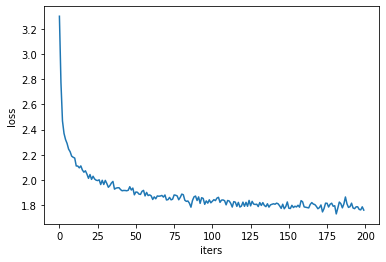

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

Well; fair'd Angeest
Doxserave durcure lose eat you which up aldoures,
Why, sir, Cyour have uncaly
With steare's sopring't!
Oull's virlty upselt that sight
Tetrionged I will not vill have I nom facporet.

LETAUTOLIA:
Why viods, tell aim's luothand
To divery to speaps. Therefore us en, Bick I may raouse a rance our wonlinguedaing to have you gone talkiwed, hath why shusely, but come I wan,

ISABELLA:
I somence the has puts they bother.

GorK:
Heir boy can mounters vioys;
And eye,
The
Intly sins,
And, and a bloody, for and a srey friege uncoffelling the gruatot
Hours, are,
Thre chuppleiey, to you
